In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [2]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASETS\new\CP_DATASET_OGplusGA"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (224, 224) # MobileNetV3Large typically uses 224x224
BATCH_SIZE = 32
EPOCHS = 30 # Can be adjusted
LEARNING_RATE = 1e-5 # Slightly higher than ResNet50 frozen, but still low

In [3]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 24007


In [4]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 19205 | Val samples: 4802


In [5]:
# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img = preprocess_input(img) # For MobileNetV3: scales pixels to [-1, 1]

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

In [6]:
# === Final Pipeline ===
train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# === MobileNetV3 Model ===
# Use MobileNetV3Large for better performance
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# It's important to set training=False when using the base model for feature extraction
# especially if it contains BatchNorm layers, to keep them in inference mode.
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), # Using label smoothing
    metrics=['accuracy']
)

In [8]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch+1}: {lr:.6f}")

# === Compute class weights ===
# Temporarily unbatch and concatenate labels to compute class weights
# y_train_int = np.argmax(np.concatenate([labels.numpy() for _, labels in train_ds.unbatch().batch(BATCH_SIZE)]), axis=1)
# class_weights = dict(enumerate(class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(len(CLASSES)),
#     y=y_train_int
# )))
# print("✅ Computed class weights:", class_weights)

In [9]:
# === Train ===
print("\n🚀 Starting Phase 1 Training (MobileNetV3 - Feature Extraction)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()] # Increased patience
    # class_weight=class_weights
)


🚀 Starting Phase 1 Training (MobileNetV3 - Feature Extraction)...
Epoch 1/30
📉 Learning rate at epoch 1: 0.000010>.] - ETA: 0s - loss: 1.3162 - accuracy: 0.4272   
601/601 [==============================] - 49s 74ms/step - loss: 1.3161 - accuracy: 0.4273 - val_loss: 1.0461 - val_accuracy: 0.6166
Epoch 2/30
📉 Learning rate at epoch 2: 0.000010>.] - ETA: 0s - loss: 1.0988 - accuracy: 0.5660 
601/601 [==============================] - 44s 72ms/step - loss: 1.0988 - accuracy: 0.5661 - val_loss: 0.9385 - val_accuracy: 0.6810
Epoch 3/30
📉 Learning rate at epoch 3: 0.000010>.] - ETA: 0s - loss: 1.0021 - accuracy: 0.6309 
601/601 [==============================] - 44s 72ms/step - loss: 1.0021 - accuracy: 0.6310 - val_loss: 0.8673 - val_accuracy: 0.7232
Epoch 4/30
📉 Learning rate at epoch 4: 0.000010>.] - ETA: 0s - loss: 0.9463 - accuracy: 0.6666 
601/601 [==============================] - 43s 72ms/step - loss: 0.9462 - accuracy: 0.6666 - val_loss: 0.8322 - val_accuracy: 0.7347
Epoch 5/30
📉 Le


📊 Evaluating Phase 1 Model...
1/1 [==============================] - 1s 595ms/step

📊 Classification Report (Phase 1):
              precision    recall  f1-score   support

      BLIGHT       0.95      0.98      0.97       720
       BLAST       0.89      0.76      0.82      1423
   BROWNSPOT       0.88      0.80      0.84      1116
     HEALTHY       0.80      0.94      0.86      1543

    accuracy                           0.86      4802
   macro avg       0.88      0.87      0.87      4802
weighted avg       0.87      0.86      0.86      4802



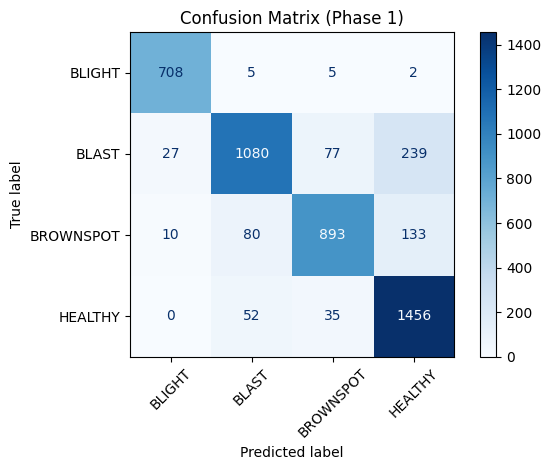

✅ Phase 1 MobileNetV3 Model saved at: C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\MobileNetV3_Phase1_aug_noaug.h5


In [10]:
# === Evaluate ===
print("\n📊 Evaluating Phase 1 Model...")
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report (Phase 1):")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Phase 1)")
plt.tight_layout()
plt.show()

# === Save ===
SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\MobileNetV3_Phase1_aug_noaug.h5"
model.save(SAVE_PATH)
print(f"✅ Phase 1 MobileNetV3 Model saved at: {SAVE_PATH}")